<a href="https://colab.research.google.com/github/fcchung/Cats-and-Dogs-Classification/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## Download Data

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   134M      0  0:00:05  0:00:05 --:--:--  140M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
 kagglecatsanddogs_3367a.zip  'MSR-LA - 3467.docx'  'readme[1].txt'
 model.png		       PetImages	     sample_data


### remove corrupted files

In [ ]:
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            # Filter out badly-encoded images 
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        
        img = cv2.imread(fpath)

        if not is_jfif or img is None or img.shape[2] != 3:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)


print("Deleted %d images" % num_skipped)

Deleted 1592 images


## Generate Dataset (Size 224, Original)

In [ ]:
image_size = (224, 224)
batch_size = 32

#load database from directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
train_ds



Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

## Data Snapshot
Dog has 1 as label <br/>
Cat has 0 as label

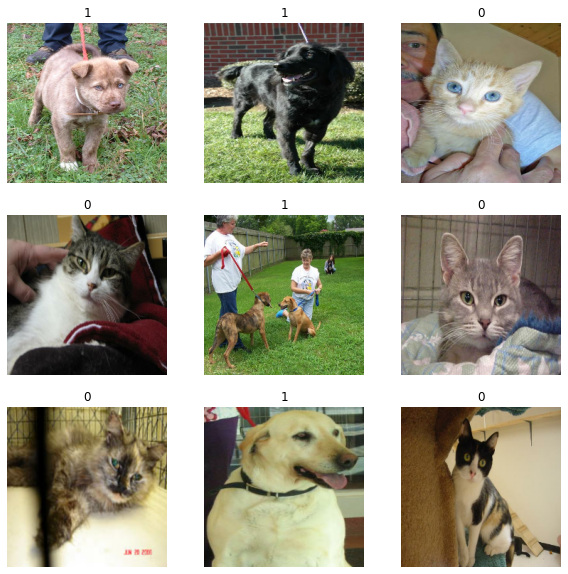

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # randomly flip it horizontally
        layers.RandomRotation(0.1), #randomly rotate 10 degrees
    ]
)

### Augmented Data Snapshot
This will transform the image by randomly rotate or flip the image

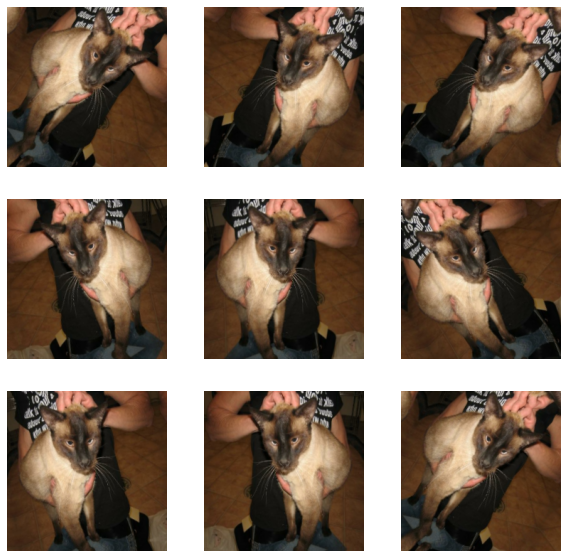

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Build Models

### Epoch

In [ ]:
epochs = 20

## Logistic Regression

## CNN Model

### VGG

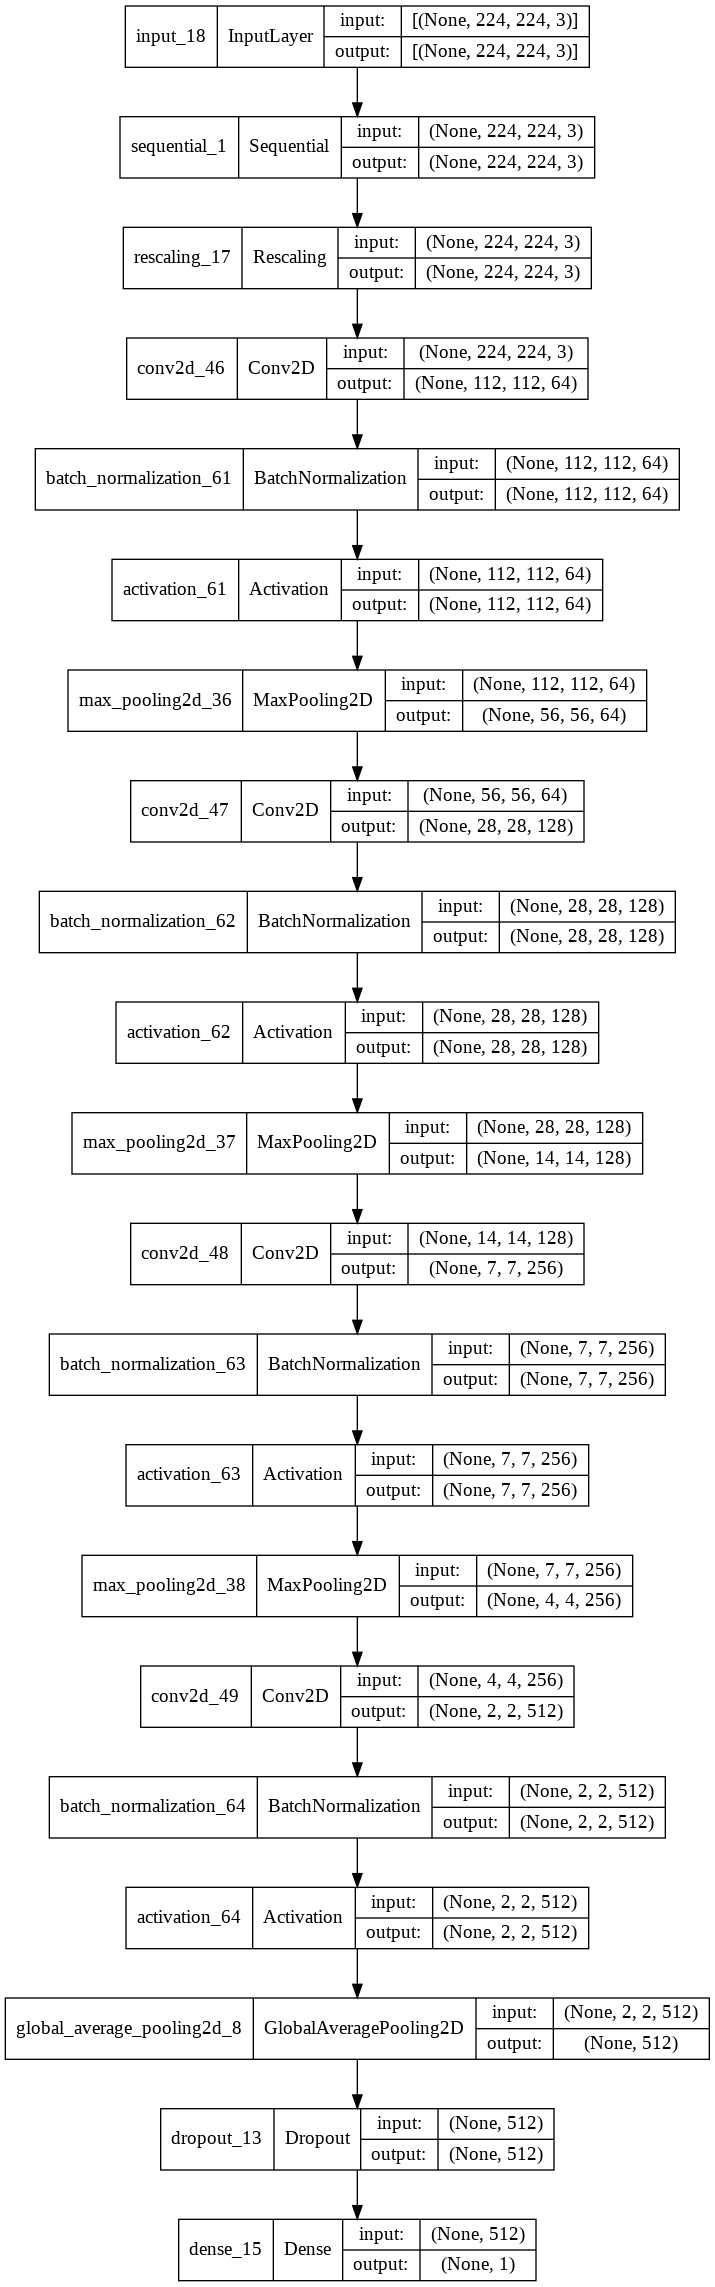

In [ ]:
def VGG_16(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = data_augmentation(inputs)
  x = layers.Rescaling(1.0 / 255)(x)
  
  #Entry block
  for size in [64, 128, 256]:
    x = layers.Conv2D(size, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  return keras.Model(inputs, outputs)

model = VGG_16(input_shape=image_size + (3,), num_classes=2)


keras.utils.plot_model(model, show_shapes=True)

    

#### VGG Result

In [ ]:
VGG_model = VGG_16(input_shape=image_size + (3,), num_classes=2)

VGG_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
VGG_model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
586/586 [==============================] - 22s 37ms/step - loss: 0.5778 - accuracy: 0.7025 - val_loss: 0.6521 - val_accuracy: 0.6679
Epoch 2/20
586/586 [==============================] - 22s 37ms/step - loss: 0.4517 - accuracy: 0.7878 - val_loss: 0.4102 - val_accuracy: 0.8159
Epoch 3/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3953 - accuracy: 0.8201 - val_loss: 0.3789 - val_accuracy: 0.8377
Epoch 4/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3520 - accuracy: 0.8446 - val_loss: 0.3287 - val_accuracy: 0.8607
Epoch 5/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3333 - accuracy: 0.8535 - val_loss: 0.4440 - val_accuracy: 0.7871
Epoch 6/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3050 - accuracy: 0.8680 - val_loss: 0.4533 - val_accuracy: 0.7892
Epoch 7/20
586/586 [==============================] - 22s 37ms/step - loss: 0.2842 - accuracy: 0.8788 - val_loss: 0.3019 - val_accuracy:

### Xception Model

In [ ]:
def CNN(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    
    #Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model = CNN(input_shape=image_size + (3,), num_classes=2)



#### Model Agritechture

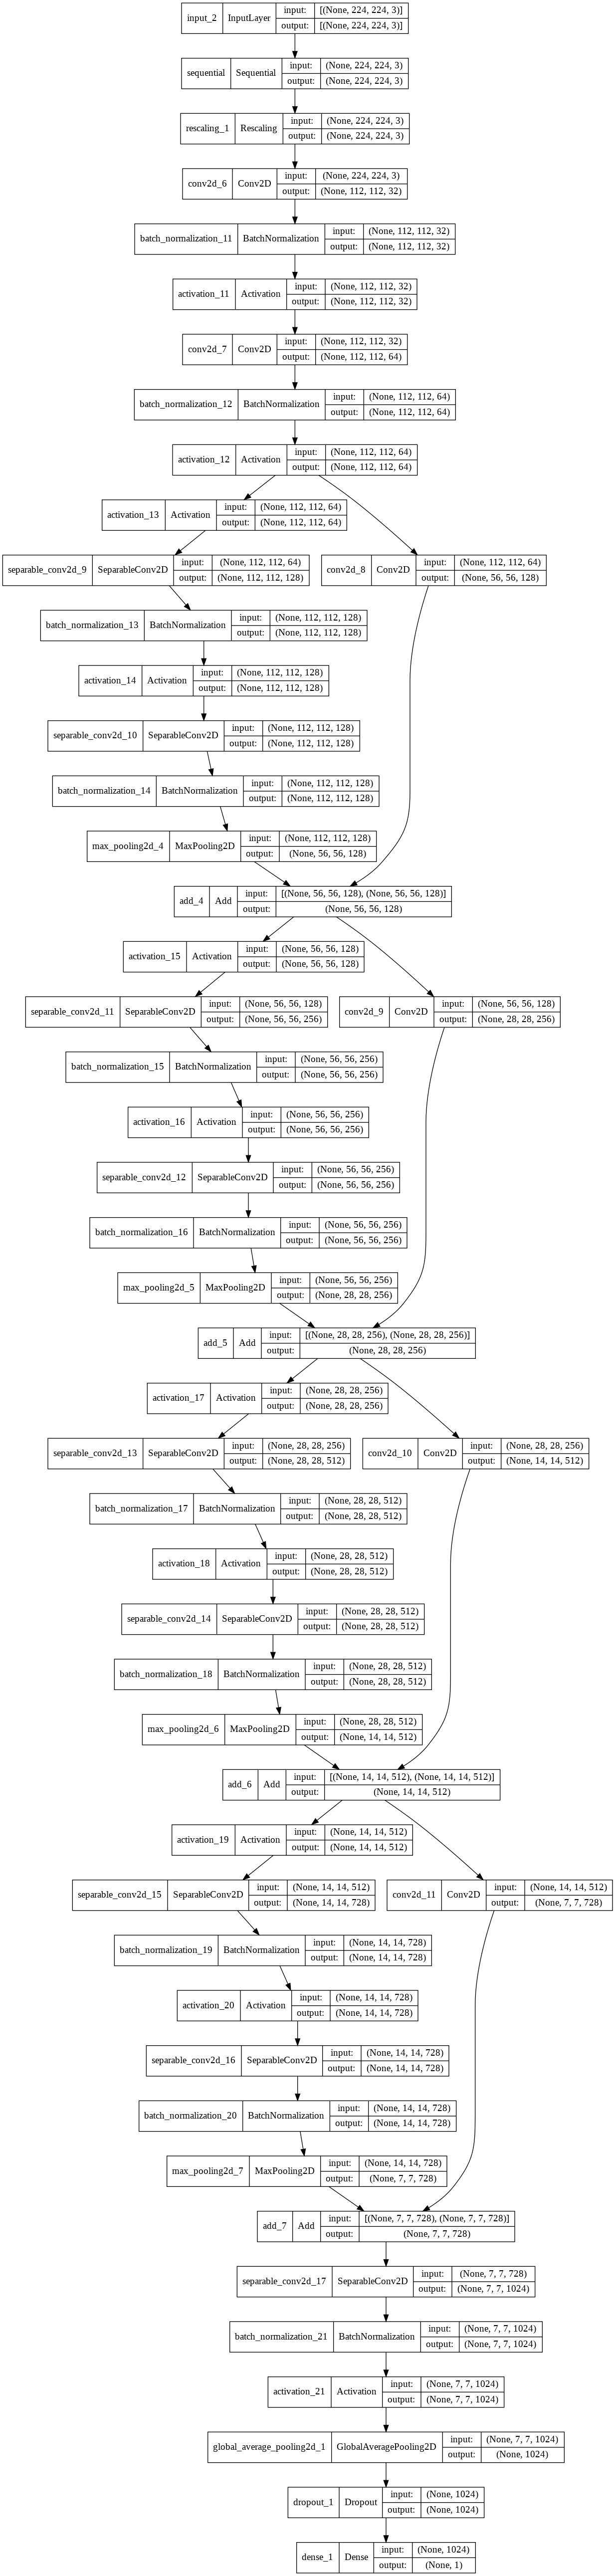

In [ ]:
keras.utils.plot_model(model, show_shapes=True)


### Xception with Original Data Size 225
Run the next cell.
Assuming that the current dataset is still same as above without any changes

#### Test Results

In [160]:
CNN_model = CNN(input_shape=image_size + (3,), num_classes=2)

CNN_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
586/586 [==============================] - 166s 279ms/step - loss: 0.6390 - accuracy: 0.6480 - val_loss: 0.5609 - val_accuracy: 0.7114
Epoch 2/20
586/586 [==============================] - 163s 278ms/step - loss: 0.5060 - accuracy: 0.7560 - val_loss: 0.5041 - val_accuracy: 0.7770
Epoch 3/20
586/586 [==============================] - 163s 278ms/step - loss: 0.4152 - accuracy: 0.8162 - val_loss: 0.3270 - val_accuracy: 0.8569
Epoch 4/20
586/586 [==============================] - 163s 279ms/step - loss: 0.3294 - accuracy: 0.8606 - val_loss: 0.4078 - val_accuracy: 0.8048
Epoch 5/20
586/586 [==============================] - 163s 279ms/step - loss: 0.2887 - accuracy: 0.8801 - val_loss: 0.9787 - val_accuracy: 0.6153
Epoch 6/20
586/586 [==============================] - 163s 278ms/step - loss: 0.2388 - accuracy: 0.8993 - val_loss: 0.6272 - val_accuracy: 0.7770
Epoch 7/20
586/586 [==============================] - 163s 278ms/step - loss: 0.2183 - accuracy: 0.9100 - val_loss: 0.1862 -

##### Nagative Results Edge Cases


In [167]:
"""
Wrong_cat and wrong dogs array will contain img is missclassify by more than 70%
"""
wrong_cats = []
wrong_cats_label = []
wrong_dogs = []
wrong_dogs_label = []
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        img = keras.preprocessing.image.load_img(fpath, target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = CNN_model.predict(img_array)
        score = predictions[0]
        if folder_name == "Cat" and score > .7:
          wrong_cats.append(img)
          wrong_cats_label.append(((1-score[0])*100))
        elif folder_name == "Dog" and score < .3:
          wrong_dogs.append(img)
          wrong_dogs_label.append(score[0]*100)



##### Edge Cases for Cats

In [214]:
edge_cats = []
edge_cats_label =[]
edge_dogs = []
edge_dogs_label = []
cat_edge_score = .5
dog_edge_score = 25
for i in range(len(wrong_cats_label)):
  if float(wrong_cats_label[i]) < cat_edge_score:
    edge_cats.append(wrong_cats[i])
    edge_cats_label.append(wrong_cats_label[i])

for i in range(len(wrong_dogs_label)):
  if float(wrong_dogs_label[i]) < dog_edge_score:
    edge_dogs.append(wrong_dogs[i])
    edge_dogs_label.append(wrong_dogs_label[i])

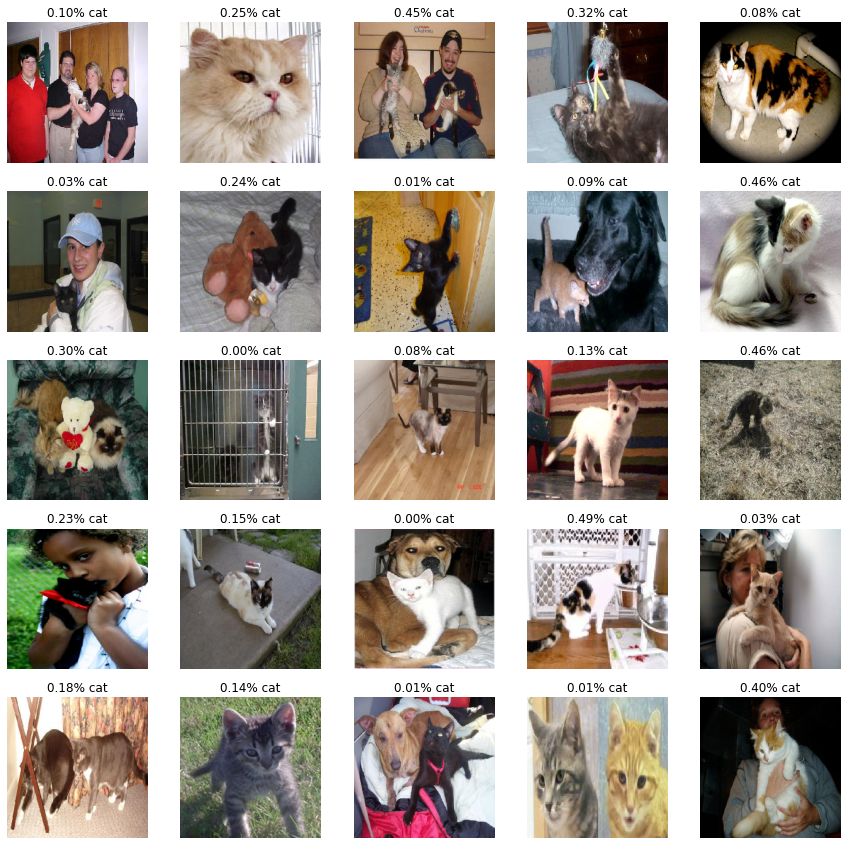

In [211]:
plt.figure(figsize=(15, 15))
for i in range(min(len(edge_cats_label),25)):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(edge_cats[i])
  plt.axis("off")
  plt.title("%.2f%% cat"%(edge_cats_label[i]))
plt.show()

##### Edge Cases for Dogs

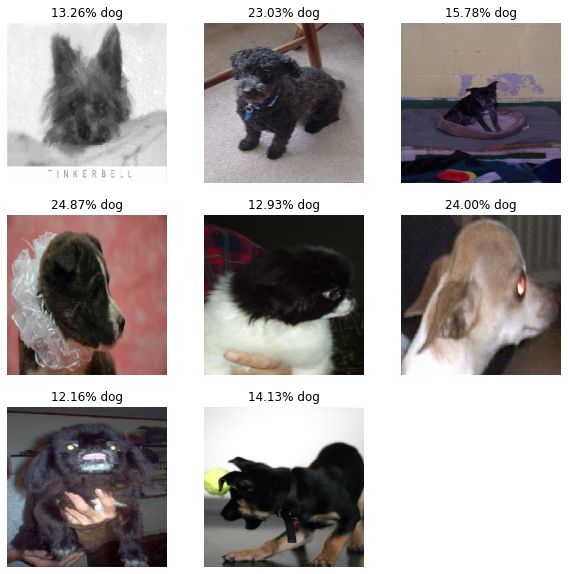

In [215]:
plt.figure(figsize=(10, 10))
for i in range(min(len(edge_dogs_label),9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(edge_dogs[i])
  plt.axis("off")
  plt.title("%.2f%% dog"%(edge_dogs_label[i]))
plt.show()

### When image Size is reduce to 180*180

In [ ]:
image_size = (180, 180)
batch_size = 32

m_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
m_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)



Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


#### Test Result

In [ ]:

CNN_m_model = CNN(input_shape=image_size + (3,), num_classes=2)

CNN_m_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_m_model.fit(
    m_train_ds, epochs=epochs, validation_data=m_val_ds,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
Epoch 1/20
586/586 [==============================] - 115s 192ms/step - loss: 0.6378 - accuracy: 0.6578 - val_loss: 0.9989 - val_accuracy: 0.5534
Epoch 2/20
586/586 [==============================] - 112s 190ms/step - loss: 0.4750 - accuracy: 0.7738 - val_loss: 0.8791 - val_accuracy: 0.6672
Epoch 3/20
586/586 [==============================] - 112s 191ms/step - loss: 0.3887 - accuracy: 0.8241 - val_loss: 0.9554 - val_accuracy: 0.6638
Epoch 4/20
586/586 [==============================] - 112s 191ms/step - loss: 0.3338 - accuracy: 0.8560 - val_loss: 0.2880 - val_accuracy: 0.8755
Epoch 5/20
586/586 [==============================] - 112s 190ms/step - loss: 0.2930 - accuracy: 0.8753 - val_loss: 0.4527 - val_accuracy: 0.7832
Epoch 6/20
586/586 [==============================] - 112s 190ms/step - loss: 0.2388 - accuracy: 0.8996 - val_loss: 0.205

### When image Size is reduce to 90*90

In [ ]:
image_size = (90 , 90)
batch_size = 32

s_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
s_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


#### Test Result

In [ ]:
CNN_s_model = CNN(input_shape=image_size + (3,), num_classes=2)

CNN_s_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_s_model.fit(
    s_train_ds, epochs=epochs, validation_data=s_val_ds,
)

Epoch 1/20
586/586 [==============================] - 41s 54ms/step - loss: 0.5979 - accuracy: 0.6902 - val_loss: 0.8126 - val_accuracy: 0.5628
Epoch 2/20
586/586 [==============================] - 31s 53ms/step - loss: 0.4610 - accuracy: 0.7829 - val_loss: 0.4069 - val_accuracy: 0.8135
Epoch 3/20
586/586 [==============================] - 31s 53ms/step - loss: 0.3946 - accuracy: 0.8213 - val_loss: 0.4982 - val_accuracy: 0.7687
Epoch 4/20
586/586 [==============================] - 31s 53ms/step - loss: 0.3509 - accuracy: 0.8418 - val_loss: 0.6518 - val_accuracy: 0.7614
Epoch 5/20
586/586 [==============================] - 31s 53ms/step - loss: 0.3209 - accuracy: 0.8621 - val_loss: 0.5466 - val_accuracy: 0.7785
Epoch 6/20
586/586 [==============================] - 31s 53ms/step - loss: 0.2929 - accuracy: 0.8744 - val_loss: 0.2821 - val_accuracy: 0.8806
Epoch 7/20
586/586 [==============================] - 31s 53ms/step - loss: 0.2694 - accuracy: 0.8849 - val_loss: 0.3267 - val_accuracy:

### CNN Without Batch Normalization

In [ ]:
def CNN_No_BN(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    
    #Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

#### Adjust Image to size 180

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

##### Test Result

In [ ]:
CNN_nob_model = CNN_No_BN(input_shape=image_size + (3,), num_classes=2)

CNN_nob_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_nob_model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
Epoch 1/20
586/586 [==============================] - 106s 177ms/step - loss: 0.6938 - accuracy: 0.5068 - val_loss: 0.6895 - val_accuracy: 0.5651
Epoch 2/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6909 - accuracy: 0.5296 - val_loss: 0.6866 - val_accuracy: 0.5528
Epoch 3/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6841 - accuracy: 0.5541 - val_loss: 0.6746 - val_accuracy: 0.5874
Epoch 4/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6806 - accuracy: 0.5690 - val_loss: 0.6799 - val_accuracy: 0.5485
Epoch 5/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6782 - accuracy: 0.5728 - val_loss: 0.6583 - val_accuracy: 0.6079
Epoch 6/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6637 - accuracy: 0.5950 - val_loss: 0.655